# Intro

In this example, I am using LangChain to build a simple LLM-powered assistant. I will focus on using:
1. Google Gemini
2. OpenAI gpt-4o-mini
3. I might add later <span style="color:red">__Meta llama3.2 via Ollama__</span>

In [1]:
# !pip install -qU \
#   langchain-core==0.3.33 \
#   langchain-openai==0.3.3 \
#   langchain-community==0.3.16

# Initialize LLM

First need to initialize an LLM. I'll use _Google Gemini_ or _OpenAI 'gpt-4.1-nano'_ model. You can get an API key from [OpenAI](https://platform.openai.com/settings/organization/api-keys).

In [2]:
AI_Provider = "GOOGLE"
# LLM_Provider = "OPENAI"

if AI_Provider == "GOOGLE":
    llm_model = "gemini-2.0-flash"
elif AI_Provider == "OPENAI":
    llm_model = "gpt-4.1-nano"  # less expensive than gpt-4o-mini

In [3]:
from dotenv import load_dotenv
import os
from getpass import getpass


load_dotenv()  # Try to load local .env file (for local dev); silently skip if not found (for CI)
os.environ[f"{AI_Provider}_API_KEY"] = os.getenv(f"{AI_Provider}_API_KEY") or getpass(f"Enter {AI_Provider} API Key: ")  # Get API key from environment or user input
if os.getenv(f"{AI_Provider}_API_KEY") is None:
    raise ValueError(f"❌ {AI_Provider}_API_KEY not found. Make sure it's in your .env file or set as a GitHub Action secret.")
else:
    print(f"✅ {AI_Provider}_API_KEY loaded successfully (not printing it for security).")

✅ GOOGLE_API_KEY loaded successfully (not printing it for security).


In [4]:
if AI_Provider == "GOOGLE":
    from langchain_google_genai import ChatGoogleGenerativeAI as ChatLLM
elif AI_Provider == "OPENAI":
    from langchain_openai import ChatOpenAI as ChatLLM

llm_creative = ChatLLM(temperature=0.9, model=llm_model)  # For unique creative responses
llm_conservative = ChatLLM(temperature=0.0, model=llm_model)  # For normal accurate responses
# print("✅", llm.invoke("What LLM version are you?").content)

# Problem Setting

I'll take an `article` _draft_ and use LangChain to generate:
1. Article title
2. Article description
3. Editor advice where I will insert an additional paragraph in the article
4. Article thumbnail image

Here is my article:

In [5]:
article = """*As a Senior Manager at PwC I worked on a project with a big insuracnce client.*

---

## The Problem Setting
I tackled a pressing issue for a large life insurance client: their computational model for projecting financial outcomes and predicting balance sheets over multiple quarters for life insurance products was prohibitively slow and costly.

### The model was built on:
- stochastic MC simulation,
- and actuarial adjustments.

### The model was smulating the folllwing factors and corresponding shocks:
| Factor | Shocks: additive / relative |
| --- | --- |
| interest rate changes | additive |
| GDP growth | multiplicative |

Each run took hours, consuming significant resources and delaying risk assessments. The client’s leadership needed a capability to run ad-hoc what-if scenarios, but the model’s runtime prevented near-real-time risk analytics.

## The goal
Build a scalable system reduced runtime 100x maintaining 0.95+ accuracy.
"""

# Main Code

## Step1

LangChain has several prompt classes and methods to organize/construct prompts.
There're min 3 components for chat agent prompts:
* __System prompt__: provides instructions to the LLM on how to behave, its objective, etc.
* __User prompt__: a user written input.
* _AI prompt__: the AI generated output. (If representing a conversation, previous generations are inserted into the next prompt and to bea part of the broader _chat history_.

E.g.:
```
You are an AI assistant doing X.          | SYSTEM PROMPT

User: Hi, what is the capital of Germany? | USER PROMPT
AI: It is Berlin                          | AI PROMPT
User: Is it big?                          | USER PROMPT
```

LangChain has _templates_ for each of these prompt types. Using templates we can insert different inputs into it, modifying the prompt based on provided inputs.

Next I initialize the system and user prompts:

In [6]:
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate

# Defining the system prompt (how the AI should act)
system_prompt = SystemMessagePromptTemplate.from_template("You are an AI assistant that helps generate article titles, summaries, and paragraphs.")

# the user prompt is provided by the user, in this case however the only dynamic input is the article
user_prompt1 = HumanMessagePromptTemplate.from_template(
    """You need to create a name for the article below:

---

{article}

---

The name should be based of the context of the article. Make sure the name is clear, catchy, and relevant to the article theme.

Output only 1 article name, no other explanation or text can be provided.""",
    input_variables=["article"]
)

We can display what our formatted human prompt would look like after inserting a value into the `article` parameter:

In [7]:
user_prompt1.format(article="TEST STRING")

HumanMessage(content='You need to create a name for the article below:\n\n---\n\nTEST STRING\n\n---\n\nThe name should be based of the context of the article. Make sure the name is clear, catchy, and relevant to the article theme.\n\nOutput only 1 article name, no other explanation or text can be provided.', additional_kwargs={}, response_metadata={})

Now we can merge the system and user prompts into a full chat prompt using the `ChatPromptTemplate`:

In [8]:
from langchain.prompts import ChatPromptTemplate

# prompt template 1: create an article title
prompt1 = ChatPromptTemplate.from_messages([system_prompt, user_prompt1])

By default, the `ChatPromptTemplate` will read the `input_variables` from each of the prompt templates inserted and allow us to use those input variables when formatting the full chat prompt template:

In [9]:
print(prompt1.format(article="TEST STRING"))

System: You are an AI assistant that helps generate article titles, summaries, and paragraphs.
Human: You need to create a name for the article below:

---

TEST STRING

---

The name should be based of the context of the article. Make sure the name is clear, catchy, and relevant to the article theme.

Output only 1 article name, no other explanation or text can be provided.


`ChatPromptTemplate` also prefixes each individual message with it's role, ie `System:`, `Human:`, or `AI:`.

In [10]:
prompt1.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are an AI assistant that helps generate article titles, summaries, and paragraphs.'), additional_kwargs={}),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['article'], input_types={}, partial_variables={}, template='You need to create a name for the article below:\n\n---\n\n{article}\n\n---\n\nThe name should be based of the context of the article. Make sure the name is clear, catchy, and relevant to the article theme.\n\nOutput only 1 article name, no other explanation or text can be provided.'), additional_kwargs={})]

Now chain the `first_prompt` template and the `llm` object defined earlier to create an LLM chain for **prompt formatting > llm generation > get output**.

Let's use __LCEL__ to construct the chain: define inputs with `{"article": lambda x: x["article"]}` and use the pipe operator (`|`) to feed the output from its left into the input to its right.

In [11]:
# chain1: inputs:article / output:article_title
chain1 = (
    {"article": lambda x: x["article"]}
    | prompt1
    | llm_creative
    | {"article_title": lambda x: x.content}
)

This first chain creates an article title:

In [12]:
article_title_msg = chain1.invoke({"article": article})
article_title_msg

{'article_title': '**"100x Speedup: Transforming Insurance Risk Modeling with Cloud Computing"**'}

This __Step1__ will be chained with other `LLMChain` steps.

## Step2

__Step2__ will summarize the article using the `article` and the newly generated `article_title`, and it'll output a new `summary` variable:

In [13]:
user_prompt2 = HumanMessagePromptTemplate.from_template(
    """You need to create a description for the article below:

---

{article}

---

Here is the article title '{article_title}'.

Output a SEO friendly article description. Do not output anything other than a description.""",
    input_variables=["article", "article_title"]
)

# prompt template 2: summarize the article
prompt2 = ChatPromptTemplate.from_messages([
    system_prompt,
    user_prompt2
])

In [14]:
# chain2: inputs:article,article_title / output:summary
chain2 = (
    {
        "article": lambda x: x["article"],
        "article_title": lambda x: x["article_title"]
    }
    | prompt2
    | llm_conservative
    | {"summary": lambda x: x.content}
)

In [15]:
article_description_msg = chain2.invoke({
    "article": article,
    "article_title": article_title_msg["article_title"]
})
article_description_msg

{'summary': "**Description:** Learn how we achieved a 100x speedup in a life insurance company's financial projection model using cloud computing. Discover how we transformed their risk assessment capabilities, enabling near-real-time analytics and significant cost savings."}

## Step3

__Step3__ will take the initial `article` and output _several fields_ that help the user to improve their writing. Since it outputs many fields we'll specify for the LLM to use __structured outputs__ to keeping the generated fields aligned with our requirements.

In [16]:
user_prompt3 = HumanMessagePromptTemplate.from_template(
    """You need to create a new paragraph for the article below:

---

{article}

---

Choose 1 paragraph to review and edit. As you edit, provide feedback to the user
for them to improve their writing.""",
    input_variables=["article"]
)

# prompt template 3: create a new article paragraph 
prompt3 = ChatPromptTemplate.from_messages([
    system_prompt,
    user_prompt3
])

To make the generated fields aligned with our requirements, we'll tell the LLM to use __structured outputs__. For this we create a _pydantic object_ and describe the required output format - this format description is then passed to our model using the `with_structured_output` method:

In [17]:
from pydantic import BaseModel, Field

class Paragraph(BaseModel):
    paragraph_original: str = Field(description="The original paragraph")
    paragraph_edited: str = Field(description="The improved edited paragraph")
    feedback: str = Field(description=(
        "Feedback on the original paragraph"
    ))

llm_structured = llm_creative.with_structured_output(Paragraph)

Let's combine all this into chain3:

In [18]:
# chain3: inputs:article / output:paragraph
chain3 = (
    {"article": lambda x: x["article"]}
    | prompt3
    | llm_structured
    | {
        "paragraph_original": lambda x: x.paragraph_original,
        "paragraph_edited": lambda x: x.paragraph_edited,
        "feedback": lambda x: x.feedback
    }
)

In [19]:
paragraph_and_feedback = chain3.invoke({"article": article})
paragraph_and_feedback

{'paragraph_original': 'I tackled a pressing issue for a large life insurance client: their computational model for projecting financial outcomes and predicting balance sheets over multiple quarters for life insurance products was prohibitively slow and costly.',
 'paragraph_edited': "The client, a major life insurance company, faced a critical challenge: their computational model for projecting financial outcomes was slow and expensive. Built on stochastic Monte Carlo simulation and actuarial adjustments, the model simulated factors like interest rate changes and GDP growth, with each run taking hours. This long runtime hindered the client's ability to perform timely risk assessments and ad-hoc scenario planning, delaying critical business decisions. The leadership team needed a faster way to run what-if scenarios and obtain near-real-time risk analytics to improve their decision-making agility.",
 'feedback': "The paragraph is well-written and clearly explains the problem. However, i

## Step4

__Step4__ will generate an image for the article. For this, first, we need a prompt. We decided it `should be 500 characters or less`: we want it to be short enough in case we want to add something later, e.g. `style`. We will use either:
- (if using Google) `gemini-2.0-flash-preview-image-generation`
- (if using OpenAI) `DallE`

In [20]:
from langchain_core.prompts import PromptTemplate

# LLM will make a prompt for an ImageModel with a format like this:
# 'Create 1 {style} of {subject} surrounded by {context_and_background}.'
style = "sketch"
context_and_background = "stars"

prompt_image = PromptTemplate(
    template=(
        """Generate a prompt with less then 500 characters to generate 1 image based on the information below.

---

{article}

---

The prompt's format should be "Create 1 [Style] of [Subject] surrounded by [Context_and_Background]".
* Subject: based on the above article.
* Style: {style}
* Context_and_Background: {context_and_background}"""
    ),
    input_variables=["article", "style", "context_and_background"]
)

The `generate_and_display` function will generate an image based on our prompt_image.

In [50]:
if AI_Provider == "GOOGLE":
    from google import genai
    from google.genai import types
    from PIL import Image
    from io import BytesIO
    import matplotlib.pyplot as plt
    from langchain_core.runnables import RunnableLambda

    # # Implementation option1: similar to DallE
    # from functools import partial
    # def gen_img_gemini(image_prompt: str) -> None:
    #     ''' Callable image generation function '''
    #     # ✅ One-time setup: pre-fill model and config
    #     client = genai.Client()
    #     generate = partial(
    #         client.models.generate_content,
    #         model="models/gemini-2.0-flash-preview-image-generation",
    #         config=types.GenerateContentConfig(response_modalities=["TEXT", "IMAGE"]))
    #     response = generate(contents=image_prompt)
    #     for part in response.candidates[0].content.parts:
    #         if part.text is not None:
    #             image_text = part.text
    #             # print(image_text)
    #         elif part.inline_data is not None:
    #             image_data = Image.open(BytesIO(part.inline_data.data))
    #             plt.imshow(image_data)
    #             plt.axis('off')
    #             plt.show()
    # gen_img_runnable = RunnableLambda(gen_img_gemini)  # ✅ Wrap in LCEL-compatible Runnable


    # Implementation option2: create a class
    from langchain_core.runnables import Runnable
    class GeminiImageGenerator(Runnable):
        def __init__(self, model="models/gemini-2.0-flash-preview-image-generation", config=types.GenerateContentConfig(response_modalities=["TEXT", "IMAGE"])):
            self.client = genai.Client()
            self.model = model
            self.config = config

        def invoke(self, prompt: str, config=None):
            response = self.client.models.generate_content(
                model=self.model,
                contents=prompt,
                config=self.config
            )
            for part in response.candidates[0].content.parts:
                if part.inline_data is not None:
                    image = Image.open(BytesIO(part.inline_data.data))
                    plt.imshow(image)
                    plt.axis('off')
                    plt.show()

    gen_img_runnable = GeminiImageGenerator()
    # image = gen_img_runnable.invoke("Generate 1 vintage map of a fantasy island.")

elif AI_Provider == "OPENAI":
    from langchain_community.utilities.dalle_image_generator import DallEAPIWrapper
    from skimage import io
    import matplotlib.pyplot as plt
    from langchain_core.runnables import RunnableLambda

    def gen_img_dalle(image_prompt):
        image_url = DallEAPIWrapper().run(image_prompt)
        image_data = io.imread(image_url)

        # show the image:
        plt.imshow(image_data)
        plt.axis('off')
        plt.show()

    # wrap this in a RunnableLambda to use with LCEL
    gen_img_runnable = RunnableLambda(gen_img_dalle)  # ✅ Wrap in LCEL-compatible Runnable

In [51]:
# gen_img_runnable = GeminiImageGenerator()
# image = gen_img_runnable.invoke('apple')

Chain image generation components using LCEL:

In [52]:
# chain4: inputs: article / outputs: image
chain4 = (
    {"article": lambda x: x["article"],
     "style": lambda x: x["style"],
     "context_and_background": lambda x: x["context_and_background"]}
    | prompt_image
    | llm_conservative
    | (lambda x: x.content)
    | gen_img_runnable
)

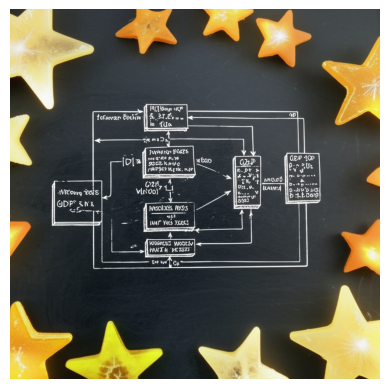

In [53]:
image = chain4.invoke({"article": article, "style": style, "context_and_background": context_and_background})

# Summary

We've built a __multi-modal__ article-helper pipeline. The developed LLM chains help with:
- creating an article title
- summarizing the article
- improving its style
- and genearating an image for it

We've used `LangChain` and `LCEL`.

___
# <span style="color:red"> __Try__ </span>
- Meta llama3.2 via Ollama
___
# <span style="color:red"> __LCEL__ </span>

In [ ]:
# # chain1: inputs:article / output:article_title
# chain1 = (
#     {"article": lambda x: x["article"]}
#     | prompt1
#     | llm_creative
#     | {"article_title": lambda x: x.content}
# )
# article_title_msg = chain1.invoke({"article": article})

# f1 = {"article": lambda x: x["article"]}
# f2 = prompt1
# f3 = llm_creative
# f4 = {"article_title": lambda x: x.content}

# step0 = {"article": article}
# print(f'step0: {step0}\n_____________________________')

# step1 = {"article": (lambda x: x["article"]) (step0)}
# print(f'step1: {step1}\n_____________________________')

# step2 = f2.format(article=step1)
# print(f'step2: {step2}\n_____________________________')

# step3 = f3.invoke(step2)
# print(f'step3: {step3}\n_____________________________')

# step4 = {"article_title": (lambda x: x.content) (step3)}
# print(f'step4: {step4}')